In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/padhai-text-non-text-classification-level-1/padhai.py
/kaggle/input/padhai-text-non-text-classification-level-1/sample_submission_level_1.csv
/kaggle/input/padhai-text-non-text-classification-level-1/level_1_test/kaggle_level_1/208.jpg
/kaggle/input/padhai-text-non-text-classification-level-1/level_1_test/kaggle_level_1/45.jpg
/kaggle/input/padhai-text-non-text-classification-level-1/level_1_test/kaggle_level_1/56.jpg
/kaggle/input/padhai-text-non-text-classification-level-1/level_1_test/kaggle_level_1/89.jpg
/kaggle/input/padhai-text-non-text-classification-level-1/level_1_test/kaggle_level_1/20.jpg
/kaggle/input/padhai-text-non-text-classification-level-1/level_1_test/kaggle_level_1/275.jpg
/kaggle/input/padhai-text-non-text-classification-level-1/level_1_test/kaggle_level_1/212.jpg
/kaggle/input/padhai-text-non-text-classification-level-1/level_1_test/kaggle_level_1/239.jpg
/kaggle/input/padhai-text-non-text-classification-level-1/level_1_test/kaggle_level_1/58.jpg
/ka

In [2]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt

np.random.seed(100)
LEVEL = 'level_2'

In [3]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)


In [4]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        image = image.convert("L")
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images


In [5]:
languages = ['ta', 'hi', 'en']
LEVEL = 'level_1'
images_train = read_all("../input/padhai-text-non-text-classification-level-1/level_1_train/"+LEVEL+"/"+"background", key_prefix='bgr_') # change the path
for language in languages:
    images_train.update(read_all("../input/padhai-text-non-text-classification-level-1/level_1_train/"+LEVEL+"/"+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all("../input/padhai-text-non-text-classification-level-1/level_1_test/kaggle_"+LEVEL, key_prefix='') # change the path
print(len(images_test))

Reading:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/447 [00:00<?, ?it/s]

Reading:


  0%|          | 0/146 [00:00<?, ?it/s]

Reading:


  0%|          | 0/149 [00:00<?, ?it/s]

Reading:


  0%|          | 0/150 [00:00<?, ?it/s]

892
Reading:


  0%|          | 0/297 [00:00<?, ?it/s]

297


In [6]:
X_train = []
Y_train = []
for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)
  
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(892, 256) (892,)
(297, 256)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?epoch/s]

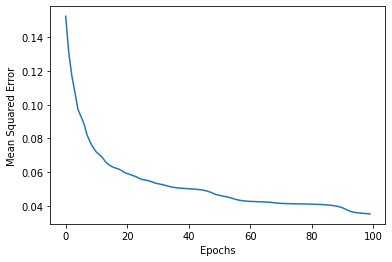

In [7]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)
sn_mse = SigmoidNeuron()
sn_mse.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.015, loss_fn="mse", display_loss=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?epoch/s]

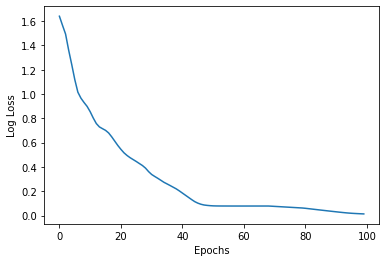

In [8]:
sn_ce = SigmoidNeuron()
sn_ce.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.015, loss_fn="ce", display_loss=True)

In [9]:
def print_accuracy(sn):
  Y_pred_train = sn.predict(X_scaled_train)
  Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
  print("Train Accuracy : ", accuracy_train)
  print("-"*50)
print_accuracy(sn_mse)
print_accuracy(sn_ce)

Train Accuracy :  0.9641255605381166
--------------------------------------------------
Train Accuracy :  0.9988789237668162
--------------------------------------------------


In [17]:
Y_pred_test = sn_ce.predict(X_scaled_test)
Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()


In [11]:

submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_binarised_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]

submission.to_csv("submisision.csv", index=False)

In [12]:
df2 = pd.DataFrame({"ImageId":[19, 242,286],
"Class":[1, 0, 0]})
submission = submission.append(df2, ignore_index = True)
submission = submission.sort_values(['ImageId'])

In [13]:
submission.to_csv("submisision1.csv", index=False)

In [14]:
submission['ImageId'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18